In [1]:
from IPython.display import HTML
HTML('''<script> 
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import r2_score
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from itertools import product
from tqdm.notebook import tqdm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

/home/adanttmm/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


load data and check first rows

In [3]:
df = pd.read_csv('/home/adanttmm/Documents/DiDi test/Jupyter notebook/Data/visitors_ts.csv',header=0,
                 names=['date','num_rest','num_visits'])
df.head()

,date,num_rest,num_visits
0,2016-01-01,1,5
1,2016-01-02,1,34
2,2016-01-03,1,17
3,2016-01-04,1,7
4,2016-01-06,3,19


check number of rows and columns in the dataset (# rows,# columns)

In [4]:
df.shape

(418, 3)

check data types and adjust dates

In [5]:
df.dtypes

date          object
num_rest       int64
num_visits     int64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

df.dtypes

date          datetime64[ns]
num_rest               int64
num_visits             int64
dtype: object

calculate basic statistics of the data

In [7]:
df.describe()

,num_rest,num_visits
count,418.000000,418.000000
mean,8.811005,117.566986
std,7.547781,125.268064
min,1.000000,2.000000
25%,2.000000,25.000000
50%,4.500000,68.500000
75%,15.000000,168.750000
max,26.000000,644.000000


there's more days than registers; some days are missing from data

In [8]:
d1 = min(df['date'])
d2 = max(df['date'])
print('Total days in the interval: %s'%((d2 - d1).days))

Total days in the interval: 516


fill in the days with no data

In [9]:
# set date to be the index
df.set_index('date',inplace=True)
# generate whole set of days between max and min dates
idx = pd.date_range(d1, d2)
# fill in the missing days
df = df.reindex(idx,fill_value=None)
df['date'] = idx

linechart to explore data

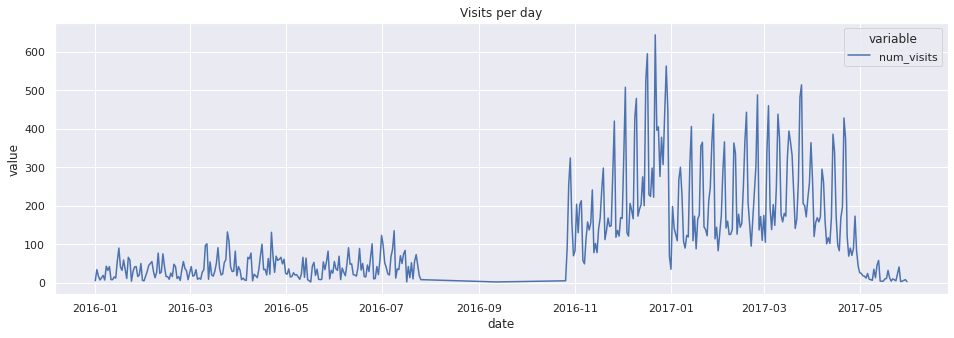

In [10]:
# reshape dataset for graphical purposes
df_melt = pd.melt(df,id_vars='date',value_vars='num_visits')

# line plot
plt.figure(figsize=(16,5))
sns.set_theme(style="darkgrid")
g = sns.lineplot(x="date", y="value",hue="variable",data=df_melt).set_title("Visits per day")



I try multiple interpolation methods to fill the missing data

In [11]:
# build imputation with mean up until July 15th 2016
aux = pd.date_range('2016-01-01', '2016-07-25')
df = df.assign(num_visits_mean = df.num_visits)
df.loc[df.num_visits.isna(),'num_visits_mean'] = df[df['date'].isin(list(aux))].num_visits.mean()

# check multiple methods of interpolation
df = df.assign(InterpolateLinear=df.num_visits.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.num_visits.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.num_visits.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.num_visits.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.num_visits.interpolate(method='slinear'))
df = df.assign(InterpolateAkima=df.num_visits.interpolate(method='akima'))
df = df.assign(InterpolatePoly5=df.num_visits.interpolate(method='polynomial', order=5)) 
df = df.assign(InterpolateSpline3=df.num_visits.interpolate(method='spline', order=3))

# meassure r2 for all methods
results = [(method, r2_score(df['num_visits_mean'], 
                             df[method])) for method in list(df)[4:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
0,InterpolateLinear,0.9842970936394834
1,InterpolateTime,0.9842970936394834
4,InterpolateSLinear,0.9842970936394834
5,InterpolateAkima,0.9833185839477034
3,InterpolateCubic,0.27895216239675524
7,InterpolateSpline3,0.27850504810584453
2,InterpolateQuadratic,0.14935865125743775
6,InterpolatePoly5,-70.99483223014931


in the end I choose to substitue missing dates with the asverage seen until July 25th, because it makes much more sense thant the trend of the other options

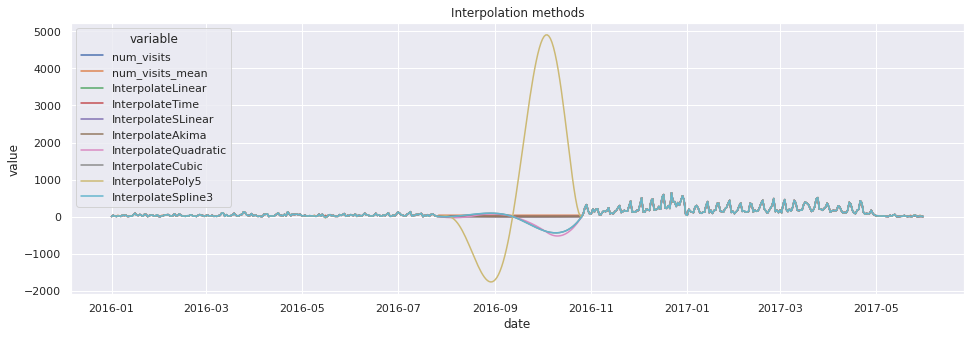

In [12]:
# reshape dataset for graphical purposes
df_melt = pd.melt(df,id_vars='date',value_vars=['num_visits','num_visits_mean','InterpolateLinear','InterpolateTime',
                                                'InterpolateSLinear','InterpolateAkima','InterpolateQuadratic',
                                                'InterpolateCubic','InterpolatePoly5','InterpolateSpline3'])

# line plot
plt.figure(figsize=(16,5))
sns.set_theme(style="darkgrid")
g = sns.lineplot(x="date", y="value",hue="variable",data=df_melt).set_title("Interpolation methods")


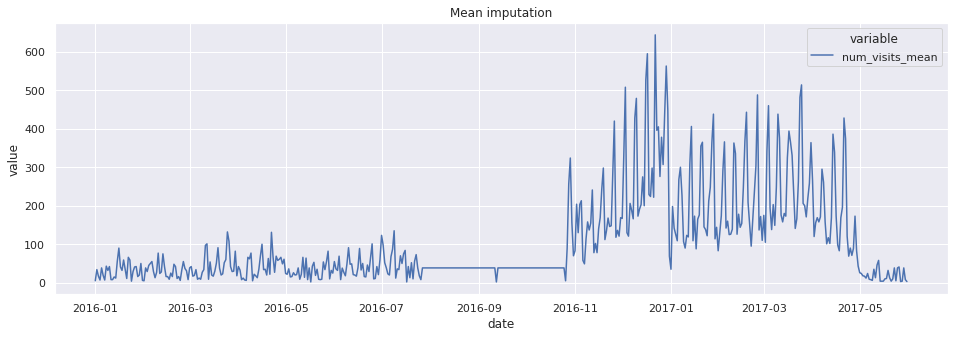

In [13]:
# reshape dataset for graphical purposes
df_melt = pd.melt(df,id_vars='date',value_vars='num_visits_mean')

# line plot
plt.figure(figsize=(16,5))
sns.set_theme(style="darkgrid")
g = sns.lineplot(x="date", y="value",hue="variable",data=df_melt).set_title("Mean imputation")

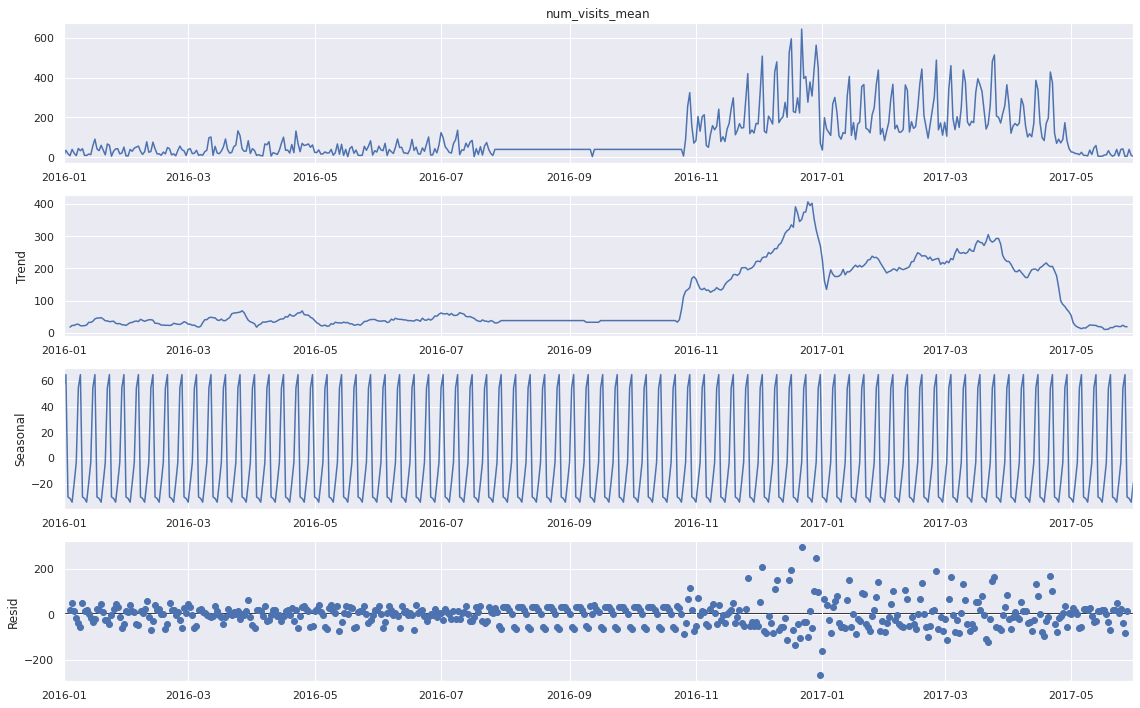

In [14]:
df_ts = df[['num_visits_mean','date']]

# seasonal decomposition
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(df_ts.num_visits_mean, model='additive')
fig = decomposition.plot()
plt.show()

I choose to drop data previous to Nov'16 to avoi heteroscedasticity issues on the model

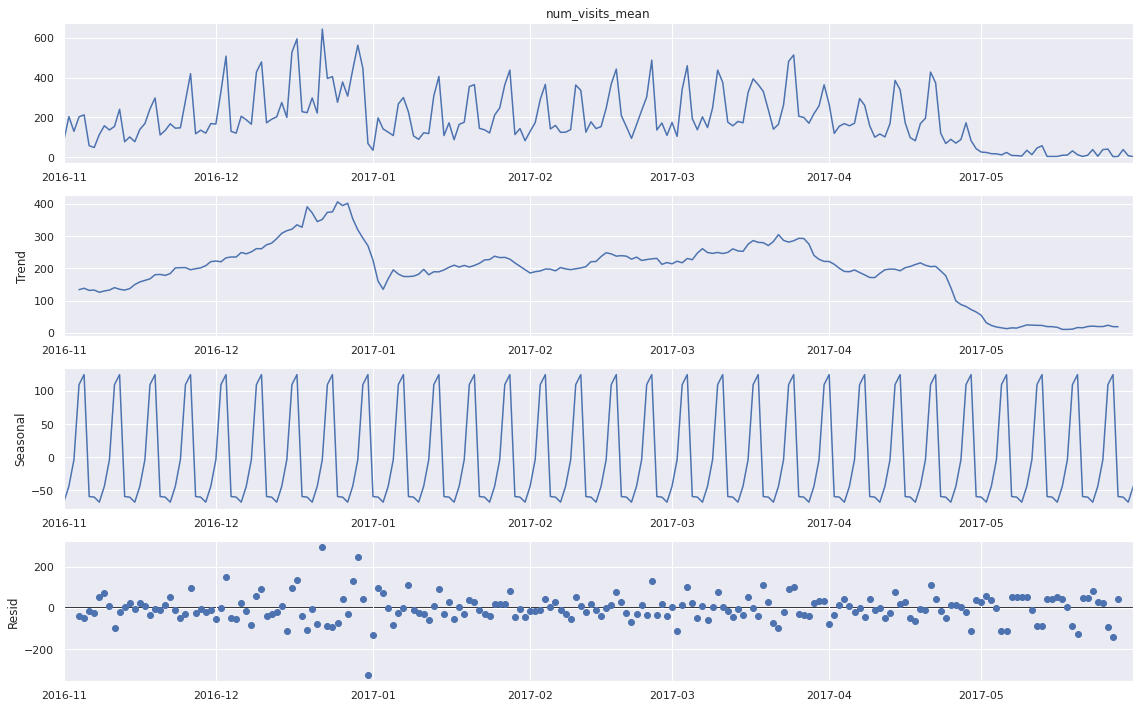

In [15]:
# drop data previous to Nov'16
aux = pd.date_range('2016-11-01','2017-05-31')
df_ts = df_ts[df_ts.index.isin(list(aux))]

# seasonal decomposition
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(df_ts.num_visits_mean, model='additive')
fig = decomposition.plot()
plt.show()

I see outliers 22nd and 31st of Dec'16 so I remove them

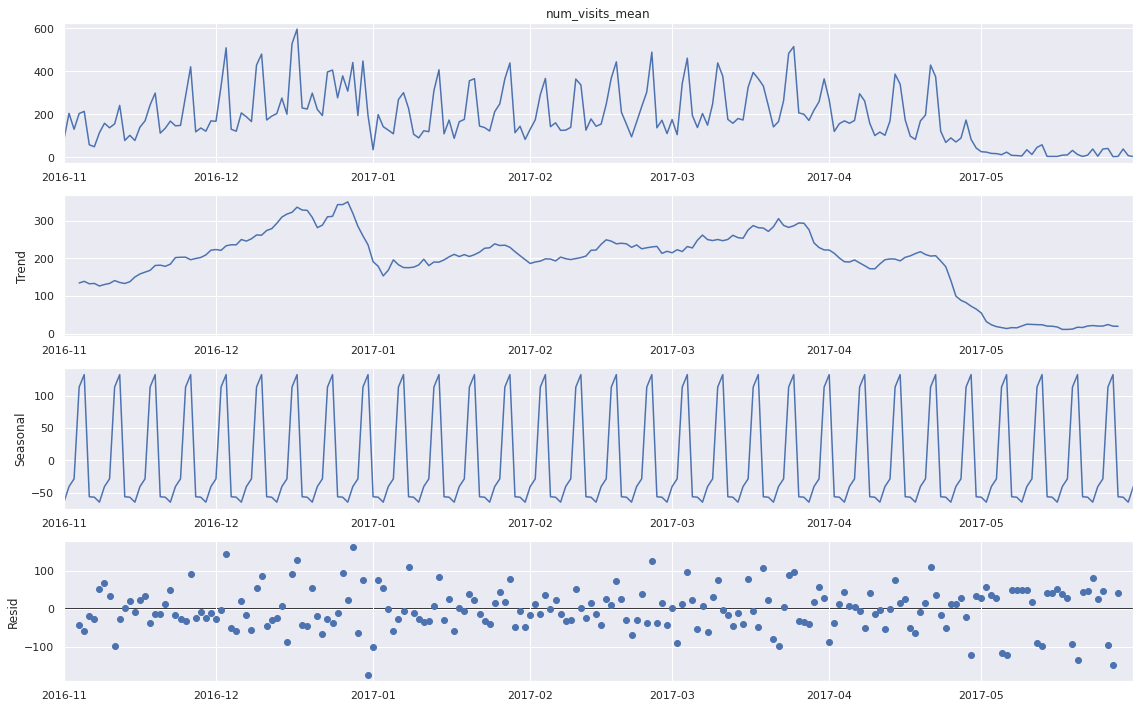

In [16]:
# remove outliers with mean prev to Jul'16
df_ts.loc[df_ts['date'].isin(['2016-12-22','2016-12-29','2016-12-31']),'num_visits_mean'] = df[df['date'].isin(list(aux))].num_visits.mean()

# seasonal decomposition
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(df_ts.num_visits_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [17]:
df_ts['seasonality'] = decomposition.seasonal
df_ts['trend'] = decomposition.trend
df_ts['residuals'] = decomposition.resid

testing stationarity of ts I see it is not (both ADF can't reject non-stationarity and KPSS rejects stationarity):

In [18]:
# ADF Test
result = adfuller(df_ts.num_visits_mean, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_ts.num_visits_mean, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3697347516351994
p-value: 0.596696612900674
Critial Values:
   1%, -3.464161278384219
Critial Values:
   5%, -2.876401960790147
Critial Values:
   10%, -2.5746921001665974

KPSS Statistic: 0.510027
p-value: 0.039408
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


checkin autocorrelation plot I see one lag difference could be enough ot have a stationary series

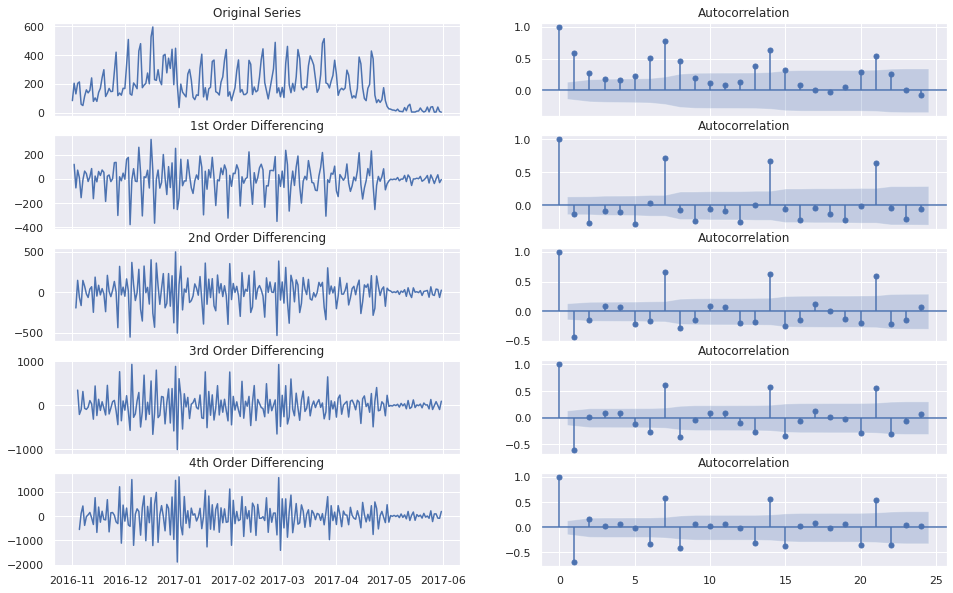

<Figure size 6768x360 with 0 Axes>

In [19]:
# Original Series
fig, axes = plt.subplots(5, 2,sharex='col',squeeze=False)
axes[0, 0].plot(df_ts.num_visits_mean); axes[0, 0].set_title('Original Series')
plot_acf(df_ts.num_visits_mean, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_ts.num_visits_mean.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_ts.num_visits_mean.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_ts.num_visits_mean.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_ts.num_visits_mean.diff().diff().dropna(), ax=axes[2, 1])


# 3rd Differencing
axes[3, 0].plot(df_ts.num_visits_mean.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df_ts.num_visits_mean.diff().diff().diff().dropna(), ax=axes[3, 1])


# 4th Differencing
axes[4, 0].plot(df_ts.num_visits_mean.diff().diff().diff().diff()); axes[4, 0].set_title('4th Order Differencing')
plot_acf(df_ts.num_visits_mean.diff().diff().diff().diff().dropna(), ax=axes[4, 1])


plt.figure(figsize=(94,5))
plt.show()

to find the lag necesary for stationarity I look at three tests which return d=1

In [20]:
## Adf Test
print('ADF test results in %d lag difference'%(ndiffs(df_ts.num_visits_mean, test='adf')))

# KPSS test
print('KPSS test results in %d lag difference'%(ndiffs(df_ts.num_visits_mean, test='kpss')))

# PP test:
print('PP test results in %d lag difference'%(ndiffs(df_ts.num_visits_mean, test='pp')))

ADF test results in 1 lag difference
KPSS test results in 1 lag difference
PP test results in 0 lag difference


with one lag the series tests stationary

In [21]:
result = adfuller(df_ts.num_visits_mean.diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.623940952234194
p-value: 0.0053194822713708585
Critial Values:
   1%, -3.464161278384219
Critial Values:
   5%, -2.876401960790147
Critial Values:
   10%, -2.5746921001665974


to find the autoregressive component AR I see in the Partial Autocorrelation that p = 6 

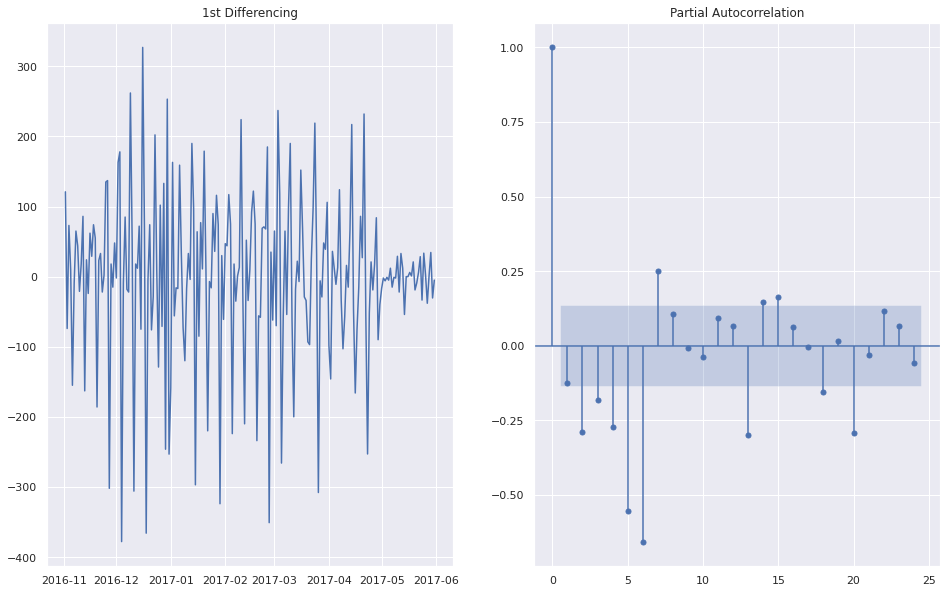

In [22]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_ts.num_visits_mean.diff()); axes[0].set_title('1st Differencing')
plot_pacf(df_ts.num_visits_mean.diff().dropna(), ax=axes[1])

plt.show()

with the autocorrelation I choose the mooving average q=2

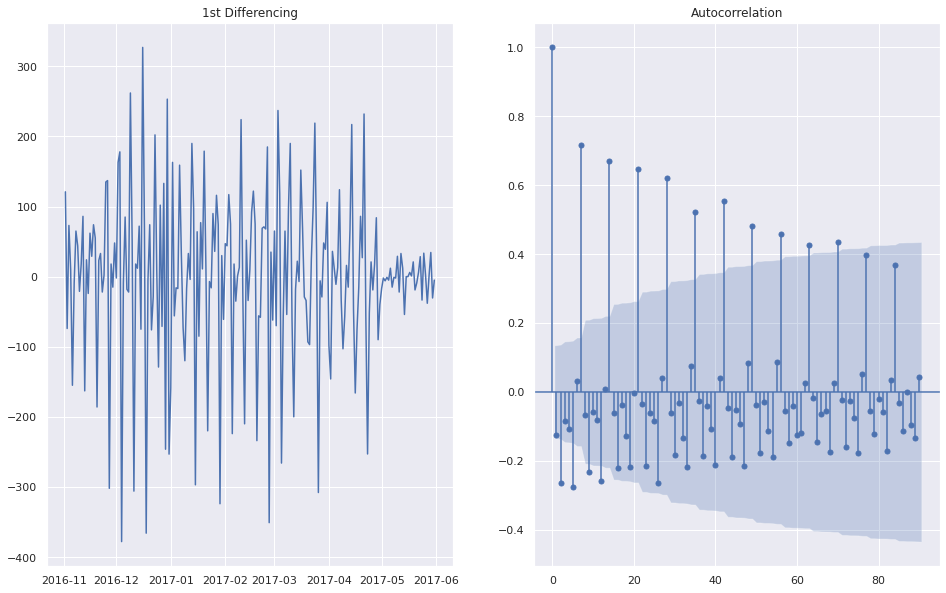

In [23]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_ts.num_visits_mean.diff()); axes[0].set_title('1st Differencing')
plot_acf(df_ts.num_visits_mean.diff().dropna(),lags=90, ax=axes[1])

plt.show()

I run a gridsearch for the pdq of the ARIMA

In [24]:
def optimize_ARIMA(parameters_list, exog):
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = ARIMA(exog, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

p = range(4, 6, 1)
d = range(0, 2, 1)
q = range(5, 6, 1)

parameters = product(p, d, q)
parameters_list = list(parameters)
print(len(parameters_list))
      
result_df = optimize_ARIMA(parameters_list, df_ts.num_visits_mean)
result_df

4


  0%|          | 0/4 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(4, 1, 5)",2414.312016
1,"(5, 1, 5)",2414.970283
2,"(5, 0, 5)",2426.969432
3,"(4, 0, 5)",2539.112379


In [25]:
result_df[result_df['AIC']==min(result_df['AIC'])]

,"(p,q)x(P,Q)",AIC
0,"(4, 1, 5)",2414.312016


In [26]:
#best_model = SARIMAX(df_ts.num_visits_mean, order=(5, 1, 0), seasonal_order=(1, 1, 1, 7)).fit(dis=-1)
best_model = ARIMA(df_ts.num_visits_mean, order=(5, 2, 5)).fit(dis=-1)
print(best_model.summary())

                             ARIMA Model Results                              
Dep. Variable:     D2.num_visits_mean   No. Observations:                  210
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1190.686
Method:                       css-mle   S.D. of innovations             68.036
Date:                Wed, 24 Feb 2021   AIC                           2405.373
Time:                        13:53:21   BIC                           2445.538
Sample:                    11-03-2016   HQIC                          2421.610
                         - 05-31-2017                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0326      0.025     -1.296      0.195      -0.082       0.017
ar.L1.D2.num_visits_mean     0.1740      0.079      2.214      0.027       0.020       0.

Text(0.5, 1.0, 'Residuals plot')

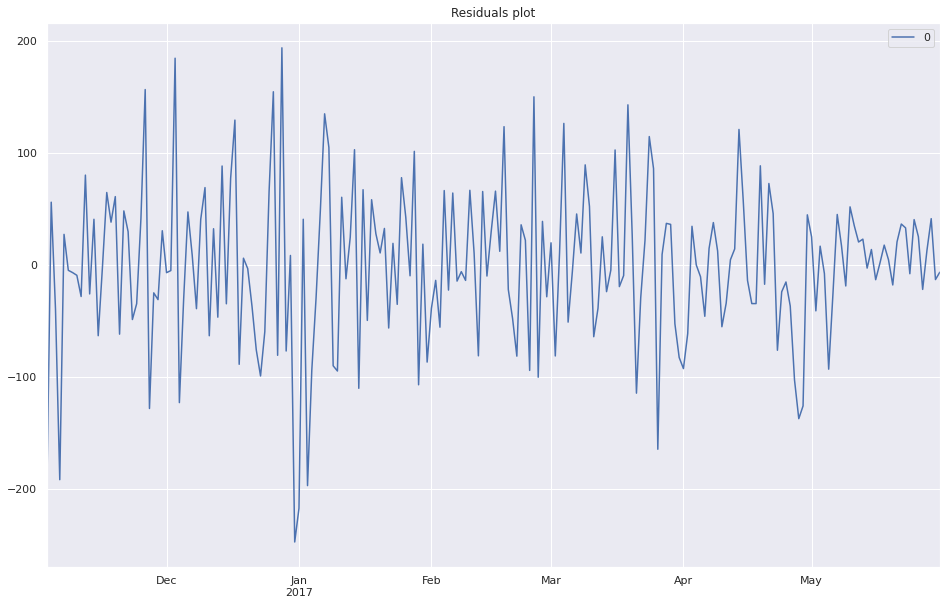

In [27]:
residuals = pd.DataFrame(best_model.resid)
residuals.plot().set_title("Residuals plot")

Text(0.5, 1.0, 'Residuals KDE')

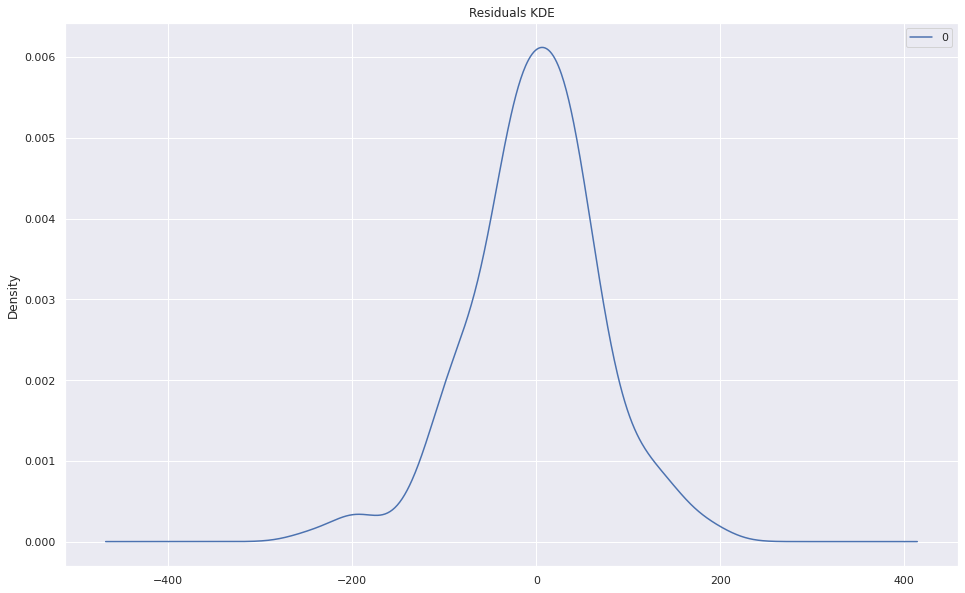

In [28]:
residuals.plot(kind='kde').set_title("Residuals KDE")

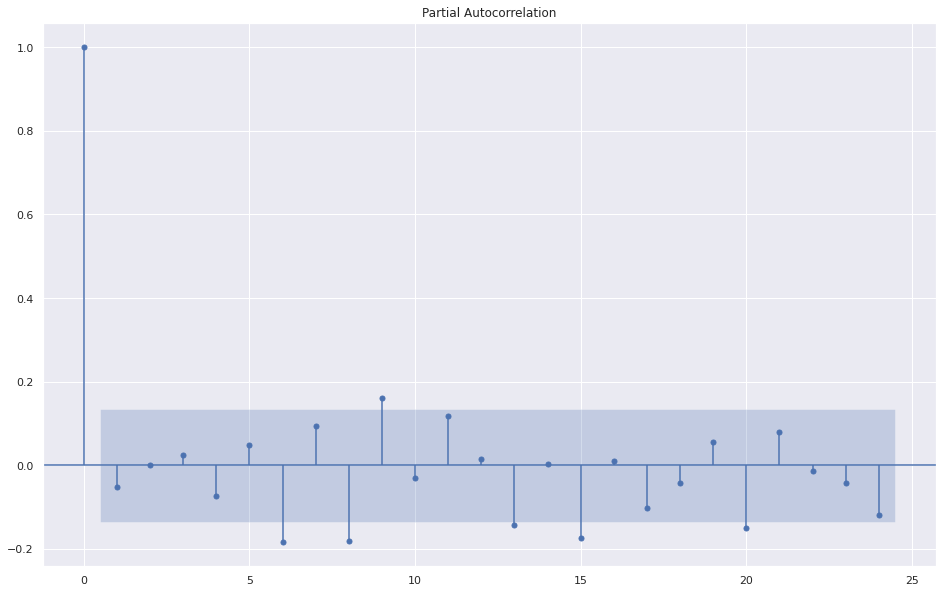

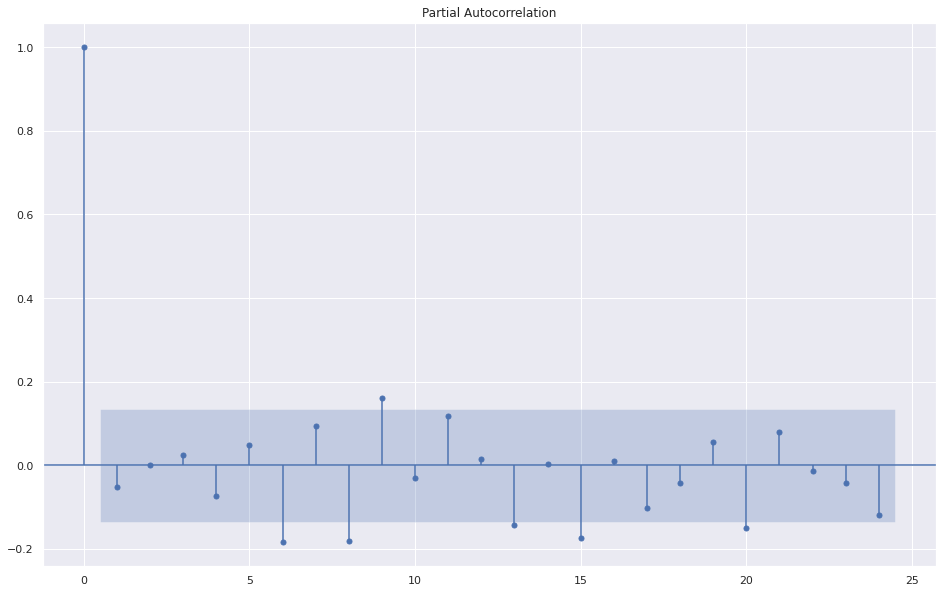

In [29]:
plot_pacf(residuals)

In [30]:
residuals.describe()

,0
count,210.000000
mean,-1.494365
std,70.963329
min,-247.592061
25%,-38.426497
50%,-0.890675
75%,40.404705
max,193.628725


check model performance

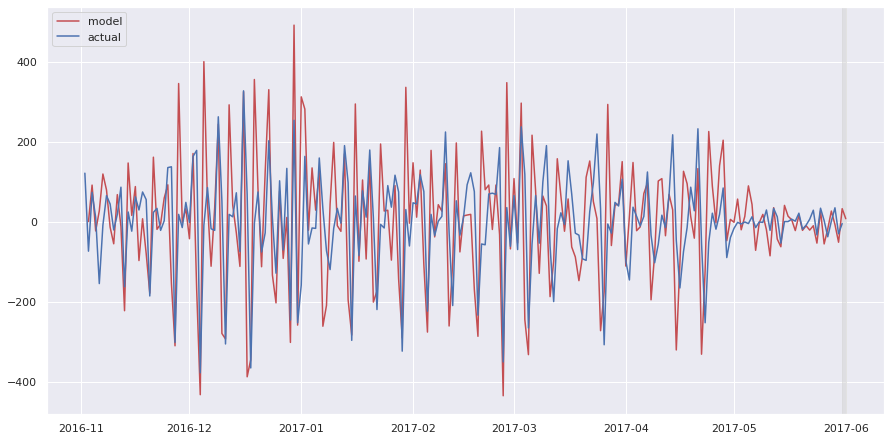

In [31]:
df_ts['arima_model'] = best_model.fittedvalues
df_ts['arima_model'][:2] = np.NaN
forecast = best_model.predict(start=df_ts.shape[0], end=df_ts.shape[0])
forecast = df_ts['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df_ts.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df_ts['num_visits_mean'].diff(), label='actual')
plt.legend()
plt.show()

In [32]:
# check model performance
mape =mean_absolute_percentage_error(df_ts.num_visits_mean[2:], best_model.predict())
print('Model with MAPE: %s'%(mape))

Model with MAPE: 1.5945920192034118


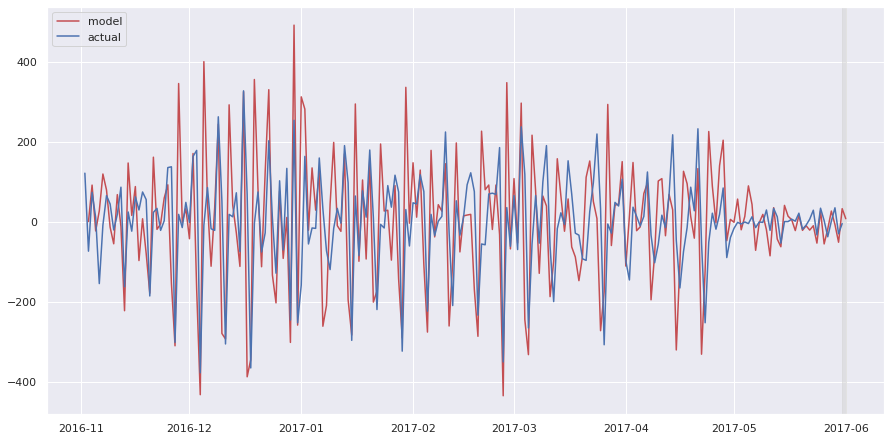

In [33]:
df_ts['arima_model'] = best_model.fittedvalues
df_ts['arima_model'][:2] = np.NaN
forecast = best_model.predict(start=df_ts.shape[0], end=df_ts.shape[0])
forecast = df_ts['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df_ts.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df_ts['num_visits_mean'].diff(), label='actual')
plt.legend()
plt.show()

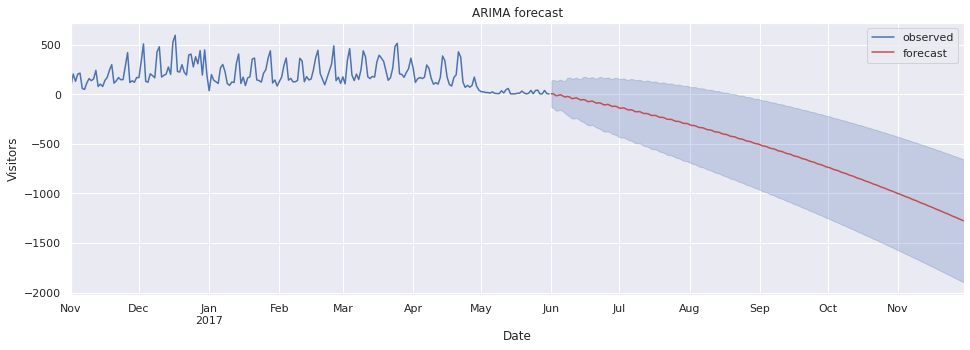

In [34]:
n=1
forecast,err,ci = best_model.forecast(183)
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range('2017-06-01','2017-11-30'))

ax = df_ts.num_visits_mean.plot(label='observed', figsize=(16, 5))
df_forecast.plot(ax=ax,label='Forecast',color='r').set_title('ARIMA forecast')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')

plt.legend()
plt.show()

given the ARIMA results I try exponential smoothing

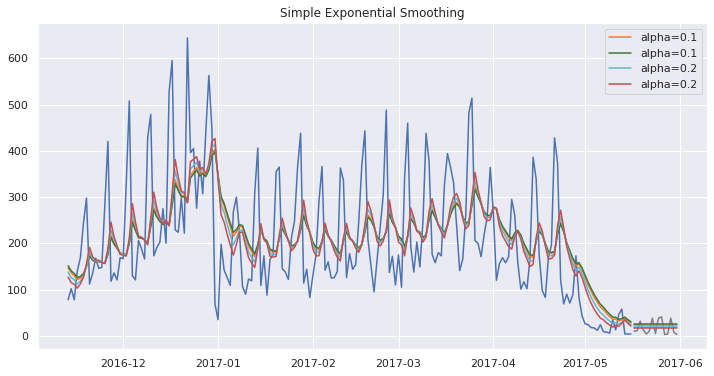

In [35]:
df_new = df[['num_visits_mean']]
train = df_new.iloc[-200:-15, :]
test = df_new.iloc[-15:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['num_visits_mean']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(15)
fit2 = model.fit(smoothing_level=.15)
pred2 = fit2.forecast(15)
fit3 = model.fit(smoothing_level=.2)
pred3 = fit3.forecast(15)
fit4 = model.fit(smoothing_level=.25)
pred4 = fit4.forecast(15)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3, pred4),(fit1, fit2, fit3, fit4),('#ff7823','#3c763d','c','r')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
 

In [36]:
# check model performance
mape_ses1 =mean_absolute_percentage_error(train, fit1.fittedvalues)
mape_ses2 =mean_absolute_percentage_error(train, fit2.fittedvalues)
mape_ses3 =mean_absolute_percentage_error(train, fit3.fittedvalues)
mape_ses4 =mean_absolute_percentage_error(train, fit4.fittedvalues)
print('Model SES 1 with MAPE: %s'%(mape_ses1))
print('Model SES 2 with MAPE: %s'%(mape_ses2))
print('Model SES 3 with MAPE: %s'%(mape_ses3))
print('Model SES 4 with MAPE: %s'%(mape_ses4))

Model SES 1 with MAPE: 0.8774065313692889
Model SES 2 with MAPE: 0.9095059086142478
Model SES 3 with MAPE: 0.8161161017931787
Model SES 4 with MAPE: 0.7657691159667872


In [37]:
mape_ses1_test =mean_absolute_percentage_error(test, pred1)
mape_ses2_test =mean_absolute_percentage_error(test, pred2)
mape_ses3_test =mean_absolute_percentage_error(test, pred3)
mape_ses4_test =mean_absolute_percentage_error(test, pred4)
print('Model SES 1 with MAPE: %s'%(mape_ses1_test))
print('Model SES 2 with MAPE: %s'%(mape_ses2_test))
print('Model SES 3 with MAPE: %s'%(mape_ses3_test))
print('Model SES 4 with MAPE: %s'%(mape_ses4_test))

Model SES 1 with MAPE: 2.4377761738592842
Model SES 2 with MAPE: 2.7071876345499173
Model SES 3 with MAPE: 1.9607644331558531
Model SES 4 with MAPE: 1.6136201968483952


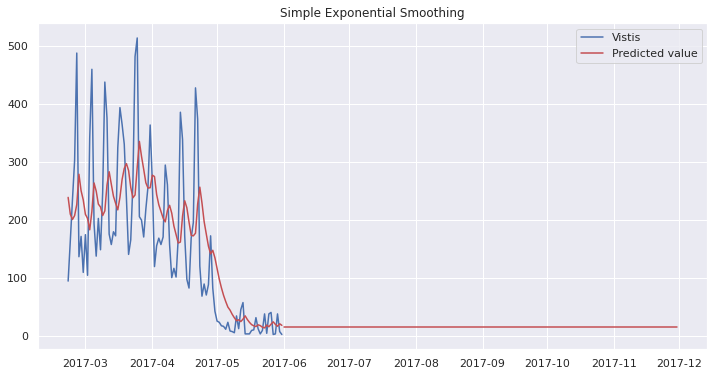

In [38]:
model_f = SimpleExpSmoothing(np.asarray(df['num_visits_mean']))
model_f._index = pd.to_datetime(df.index)

fit_f = model_f.fit(smoothing_level=0.2)
pred_f = fit_f.forecast(183)
indx_pred = pd.date_range('2017-06-01','2017-11-30')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index[-100:], df.num_visits_mean[-100:],label="Vistis")
ax.plot(df.index[-100:], fit_f.fittedvalues[-100:], color='r')
ax.plot(indx_pred, pred_f, label="Predicted value", color='r')
plt.title("Simple Exponential Smoothing")    
plt.legend();

In [39]:
pred_f.mean()

15.590337669165983

In [40]:
pred_f.sum()

2853.031793457375

In [41]:
df[-30:].num_visits.sum()*6

2556.0